# Playing with neural painters

In this notebook I play with stylized neural painters, and try to figure out how the repo works.

In [1]:
# Set working directory
%cd ..

/home/jovyan/stylized-neural-painting


In [2]:
# import libraries
import torch
import utils
import cv2
import numpy as np
import matplotlib.pyplot as plt

from painter import ProgressivePainter
from attrdict import AttrDict

# Decide which device we want to run on
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Progressive renderer

First, we can do some inference by playing with the progressive renderer. That way we can extract some tensors and generally poke around. We do this by unpacking the `demo_prog.py` python script into this notebook, step by step.

### Initialise progressive painter

First we set the renderer's parameters using the values below and then initialise a painter:

In [3]:
# Set parameters
painter_args = AttrDict(
    img_path                = './test_images/apple.jpg',
    renderer                = 'oilpaintbrush',
    canvas_color            = 'black',
    canvas_size             = 512,
    keep_aspect_ratio       = False,
    max_m_strokes           = 500,
    max_divide              = 5,
    beta_L1                 = 1.0,
    with_ot_loss            = False,
    beta_ot                 = 0.1,
    net_G                   = 'zou-fusion-net',
    renderer_checkpoint_dir = r'./checkpoints_G',
    lr                      = 2e-4,
    output_dir              = r'./output',
    disable_preview         = True
)

# Initialise a progressive painter
pt = ProgressivePainter(args=painter_args)

initialize network with normal


### Load model checkpoint + architecture

Below we load our model checkpoint and architecture. We can see each of the neural nets as well as their component layers and hyperparameters (Conv filter sizes, kernels + sizes, hidden layer widths etc).

Interestingly they seem to use `PixelShuffleNet` and `DCGAN`.

In [4]:
# Load the model checkpoint specified in painter_args
pt._load_checkpoint()

# Display the model architecture
pt.net_G.eval()

loading renderer from pre-trained checkpoint...


ZouFCNFusion(
  (huangnet): PixelShuffleNet(
    (fc1): Linear(in_features=5, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=1024, bias=True)
    (fc3): Linear(in_features=1024, out_features=2048, bias=True)
    (fc4): Linear(in_features=2048, out_features=4096, bias=True)
    (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv5): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv6): Conv2d(8, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pixel_shuffle): PixelShuffle(upscale_factor=2)
  )
  (dcgan): DCGAN(
    (main): Sequential(
      (0): ConvTranspose2d(12, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, moment

### Renderer parameter values

The `pt` painter object comes with an attribute `rderr` which contains a bunch of values to set the renderer's behaviour. We take a look inside in the code chunk below:

In [5]:
pt.rderr.__dict__

{'CANVAS_WIDTH': 512,
 'renderer': 'oilpaintbrush',
 'stroke_params': None,
 'canvas_color': 'black',
 'canvas': array([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        ...,
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0

There are a number of tensors contained in the `rdrr` object. The first of these is the `canvas`, which looks to be a 512 x 512 grid of 3 RGB values.

In [6]:
pt.rderr.canvas.shape

(512, 512, 3)

In [7]:
# As you can see, the canvas values are all zero
np.all(pt.rderr.canvas == 0)

True

Next, there are 4 tensors titled `brush_small_vertical`, `brush_small_horizontal`, `brush_large_vertical` and `brush_large_horizontal`.


brush_small_vertical:
shape=(197, 101)  mean=123.25  min=0.00  max=255.00


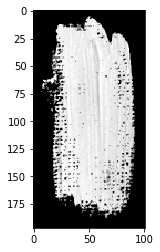


brush_small_horizontal:
shape=(197, 101)  mean=128.59  min=0.00  max=255.00


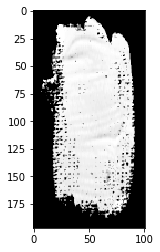


brush_large_vertical:
shape=(394, 394)  mean=132.30  min=0.00  max=254.00


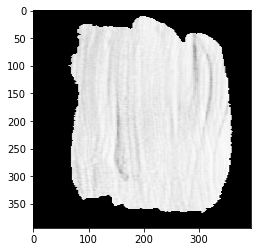


brush_large_horizontal:
shape=(394, 394)  mean=131.62  min=0.00  max=252.00


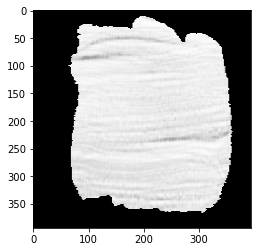

In [8]:
from itertools import product
sizes = ['small', 'large']
directions = ['vertical', 'horizontal']
for size, direction in product(sizes, directions):
    tensor_name = f'brush_{size}_{direction}'
    brush_tensor = pt.rderr.__dict__[tensor_name]
    print()
    print(tensor_name + ':\nshape=', end = '')
    print(brush_tensor.shape, end = ' ')
    print(f' mean={np.mean(brush_tensor):.2f}', end = ' ')
    print(f' min={np.min(brush_tensor):.2f}', end = ' ')
    print(f' max={np.max(brush_tensor):.2f}')
    plt.imshow(brush_tensor, cmap='gray')
    plt.show()

### Initialise parameters + canvas

In [9]:
# Set parameter values
PARAMS = np.zeros([1, 0, pt.rderr.d], np.float32)

# Create a temporary canvas
if pt.rderr.canvas_color == 'white':
    CANVAS_tmp = torch.ones([1, 3, pt.net_G.out_size, pt.net_G.out_size]).to(device)
else:
    CANVAS_tmp = torch.zeros([1, 3, pt.net_G.out_size, pt.net_G.out_size]).to(device)

## Main painter loop

The next bit is the main painter loop, so before starting we will step through a single loop one step at a time. This should help us figure out what's going on inside the model.

In [10]:
# Create painter loop iterable and take the first one
m_grids = range(1, pt.max_divide + 1)
pt.m_grid = m_grids.start
print(f'm_grid={pt.m_grid}')

m_grid=1


### Grab an image patch

We grab an image patch by subdividing the image into `m_grid` downsampled 128 x 128 patches.

In [11]:
# Grab a 128x128 image patch
pt.img_batch = utils.img2patches(
    pt.img_,           # The reference image
    pt.m_grid,         # The grid size (e.g. 5 means a 5 by 5 grid)
    pt.net_G.out_size  # The size of the output layer of the net_G network, i.e. 128
).to(device)

In [12]:
# Show image batch size
pt.img_batch.shape

torch.Size([1, 3, 128, 128])

### Display image patches

The plot below shows how the image is divided into a batch of `m_grid ** 2` 128 x 128 pixel patches.

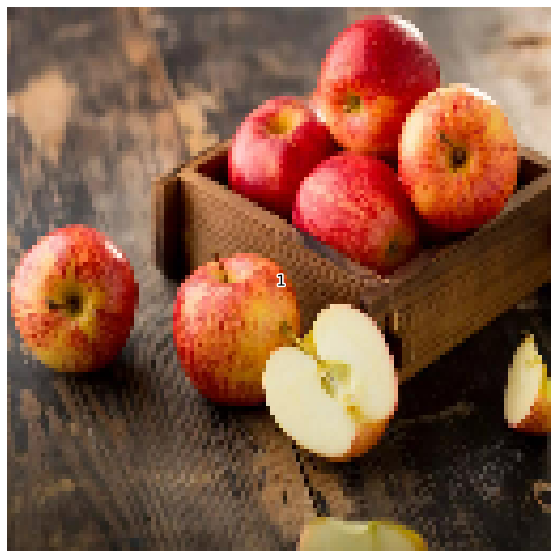

In [13]:
import matplotlib.patheffects as PathEffects

# Display image batch
num_patches = pt.img_batch.shape[0]
plt.figure(figsize=(10,10))
for i, j in product(range(pt.m_grid), range(pt.m_grid)):
    patch_num = pt.m_grid*i + j
    plt.subplot(pt.m_grid, pt.m_grid, patch_num + 1)
    plt.text(pt.net_G.out_size / 2, 
             pt.net_G.out_size / 2, 
             str(patch_num+1), 
             ha='center', 
             va='center',
             fontsize=15
        ).set_path_effects(
        [PathEffects.withStroke(
            linewidth=3, foreground='w'
    )])
    plt.imshow(pt.img_batch[patch_num,:,:,:].permute(1,2,0).cpu())
    plt.axis('off')
    plt.subplots_adjust(hspace=0.1, wspace=0)
plt.show()

## Initialise painter parameters

In [14]:
pt.initialize_params()
pt.x_ctt.requires_grad = True
pt.x_color.requires_grad = True
pt.x_alpha.requires_grad = True
utils.set_requires_grad(pt.net_G, False)

In [15]:
pt.optimizer_x = torch.optim.RMSprop([pt.x_ctt, pt.x_color, pt.x_alpha], lr=pt.lr, centered=True)

## Begin painter loop

Now that we're inside there are two more loops for us to care about. The first is the `strokes_per_block` and the next is `iters_per_stroke`.

In [16]:
pt.step_id = 0

# Show the number of loops
iters_per_stroke = int(500 / pt.m_strokes_per_block)
print(f"m_strokes_per_block={pt.m_strokes_per_block}")
print(f"iters_per_stroke={iters_per_stroke}")

m_strokes_per_block=9
iters_per_stroke=55


In [17]:
anchor_ids = range(0, pt.m_strokes_per_block)
pt.anchor_id = anchor_ids.start
pt.stroke_sampler(pt.anchor_id)

In [18]:
# Initialise the canvas
pt.G_pred_canvas = CANVAS_tmp

In [19]:
# Update x
pt.optimizer_x.zero_grad()

In [20]:
pt.x_ctt.data = torch.clamp(pt.x_ctt.data, 0.1, 1 - 0.1)
pt.x_color.data = torch.clamp(pt.x_color.data, 0, 1)
pt.x_alpha.data = torch.clamp(pt.x_alpha.data, 0, 1)

for data in ['x_ctt', 'x_color', 'x_alpha']:
    data_tensor = pt.__dict__[data].data
    print(data + ': ' + str(data_tensor.shape))
    print(f'mean={data_tensor.mean():.2f}', end = ' ')
    print(f'min={data_tensor.min():.2f}', end = ' ')
    print(f'max={data_tensor.max():.2f}', end = ' ')
    print('\n')

x_ctt: torch.Size([1, 9, 5])
mean=0.43 min=0.10 max=0.90 

x_color: torch.Size([1, 9, 6])
mean=0.48 min=0.03 max=0.98 

x_alpha: torch.Size([1, 9, 1])
mean=0.71 min=0.30 max=0.99 



In [21]:
pt._forward_pass()
pt._drawing_step_states()
pt._backward_x()

iteration step 0, G_loss: 0.00000, step_acc: 6.99251, grid_scale: 1 / 5, strokes: 1 / 9

In [22]:
pt.x_ctt.data = torch.clamp(pt.x_ctt.data, 0.1, 1 - 0.1)
pt.x_color.data = torch.clamp(pt.x_color.data, 0, 1)
pt.x_alpha.data = torch.clamp(pt.x_alpha.data, 0, 1)

for data in ['x_ctt', 'x_color', 'x_alpha']:
    data_tensor = pt.__dict__[data].data
    print(data + ': ' + str(data_tensor.shape))
    print(f'mean={data_tensor.mean():.2f}', end = ' ')
    print(f'min={data_tensor.min():.2f}', end = ' ')
    print(f'max={data_tensor.max():.2f}', end = ' ')
    print('\n')

x_ctt: torch.Size([1, 9, 5])
mean=0.43 min=0.10 max=0.90 

x_color: torch.Size([1, 9, 6])
mean=0.48 min=0.03 max=0.98 

x_alpha: torch.Size([1, 9, 1])
mean=0.71 min=0.30 max=0.99 



In [23]:
pt.optimizer_x.step()
pt.step_id += 1

## Finish the remaining steps

In [24]:
for pt.anchor_id in range(1, pt.m_strokes_per_block):
    pt.stroke_sampler(pt.anchor_id)
    iters_per_stroke = int(500 / pt.m_strokes_per_block)
    for i in range(1, iters_per_stroke):
        pt.G_pred_canvas = CANVAS_tmp

        # update x
        pt.optimizer_x.zero_grad()

        pt.x_ctt.data = torch.clamp(pt.x_ctt.data, 0.1, 1 - 0.1)
        pt.x_color.data = torch.clamp(pt.x_color.data, 0, 1)
        pt.x_alpha.data = torch.clamp(pt.x_alpha.data, 0, 1)

        pt._forward_pass()
        pt._drawing_step_states()
        pt._backward_x()

        pt.x_ctt.data = torch.clamp(pt.x_ctt.data, 0.1, 1 - 0.1)
        pt.x_color.data = torch.clamp(pt.x_color.data, 0, 1)
        pt.x_alpha.data = torch.clamp(pt.x_alpha.data, 0, 1)

        pt.optimizer_x.step()
        pt.step_id += 1

iteration step 432, G_loss: 0.20729, step_acc: 11.09922, grid_scale: 1 / 5, strokes: 9 / 9

In [25]:
v = pt._normalize_strokes(pt.x)

In [26]:
v.shape

(1, 9, 12)

In [27]:
v = pt._shuffle_strokes_and_reshape(v)

In [28]:
v.shape

(1, 9, 12)

In [29]:
PARAMS = np.concatenate([PARAMS, v], axis=1)


rendering canvas...


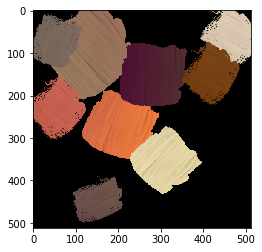

In [30]:
CANVAS_tmp = pt._render(PARAMS, save_jpgs=False, save_video=False)
plt.imshow(CANVAS_tmp)

In [31]:
CANVAS_tmp = utils.img2patches(CANVAS_tmp, pt.m_grid + 1, pt.net_G.out_size).to(device)

In [32]:
CANVAS_tmp.shape

torch.Size([4, 3, 128, 128])

### Finish for every m_grid

In [33]:
for pt.m_grid in range(2, pt.max_divide + 1):

        pt.img_batch = utils.img2patches(pt.img_, pt.m_grid, pt.net_G.out_size).to(device)
        pt.G_final_pred_canvas = CANVAS_tmp

        pt.initialize_params()
        pt.x_ctt.requires_grad = True
        pt.x_color.requires_grad = True
        pt.x_alpha.requires_grad = True
        utils.set_requires_grad(pt.net_G, False)

        pt.optimizer_x = torch.optim.RMSprop([pt.x_ctt, pt.x_color, pt.x_alpha], lr=pt.lr, centered=True)

        pt.step_id = 0
        for pt.anchor_id in range(0, pt.m_strokes_per_block):
            pt.stroke_sampler(pt.anchor_id)
            iters_per_stroke = int(500 / pt.m_strokes_per_block)
            for i in range(iters_per_stroke):
                pt.G_pred_canvas = CANVAS_tmp

                # update x
                pt.optimizer_x.zero_grad()

                pt.x_ctt.data = torch.clamp(pt.x_ctt.data, 0.1, 1 - 0.1)
                pt.x_color.data = torch.clamp(pt.x_color.data, 0, 1)
                pt.x_alpha.data = torch.clamp(pt.x_alpha.data, 0, 1)

                pt._forward_pass()
                pt._drawing_step_states()
                pt._backward_x()

                pt.x_ctt.data = torch.clamp(pt.x_ctt.data, 0.1, 1 - 0.1)
                pt.x_color.data = torch.clamp(pt.x_color.data, 0, 1)
                pt.x_alpha.data = torch.clamp(pt.x_alpha.data, 0, 1)

                pt.optimizer_x.step()
                pt.step_id += 1

        v = pt._normalize_strokes(pt.x)
        v = pt._shuffle_strokes_and_reshape(v)
        PARAMS = np.concatenate([PARAMS, v], axis=1)
        CANVAS_tmp = pt._render(PARAMS, save_jpgs=False, save_video=False)
        CANVAS_tmp = utils.img2patches(CANVAS_tmp, pt.m_grid + 1, pt.net_G.out_size).to(device)

iteration step 494, G_loss: 0.12953, step_acc: 14.78360, grid_scale: 2 / 5, strokes: 9 / 9
rendering canvas...
iteration step 494, G_loss: 0.09005, step_acc: 17.34700, grid_scale: 3 / 5, strokes: 9 / 9
rendering canvas...
iteration step 494, G_loss: 0.07343, step_acc: 19.06548, grid_scale: 4 / 5, strokes: 9 / 9
rendering canvas...
iteration step 494, G_loss: 0.06235, step_acc: 20.53419, grid_scale: 5 / 5, strokes: 9 / 9
rendering canvas...


In [34]:
pt._save_stroke_params(PARAMS)

saving stroke parameters...


In [35]:
final_rendered_image = pt._render(PARAMS, save_jpgs=True, save_video=True)


rendering canvas...
saving input photo...
saving final rendered result...


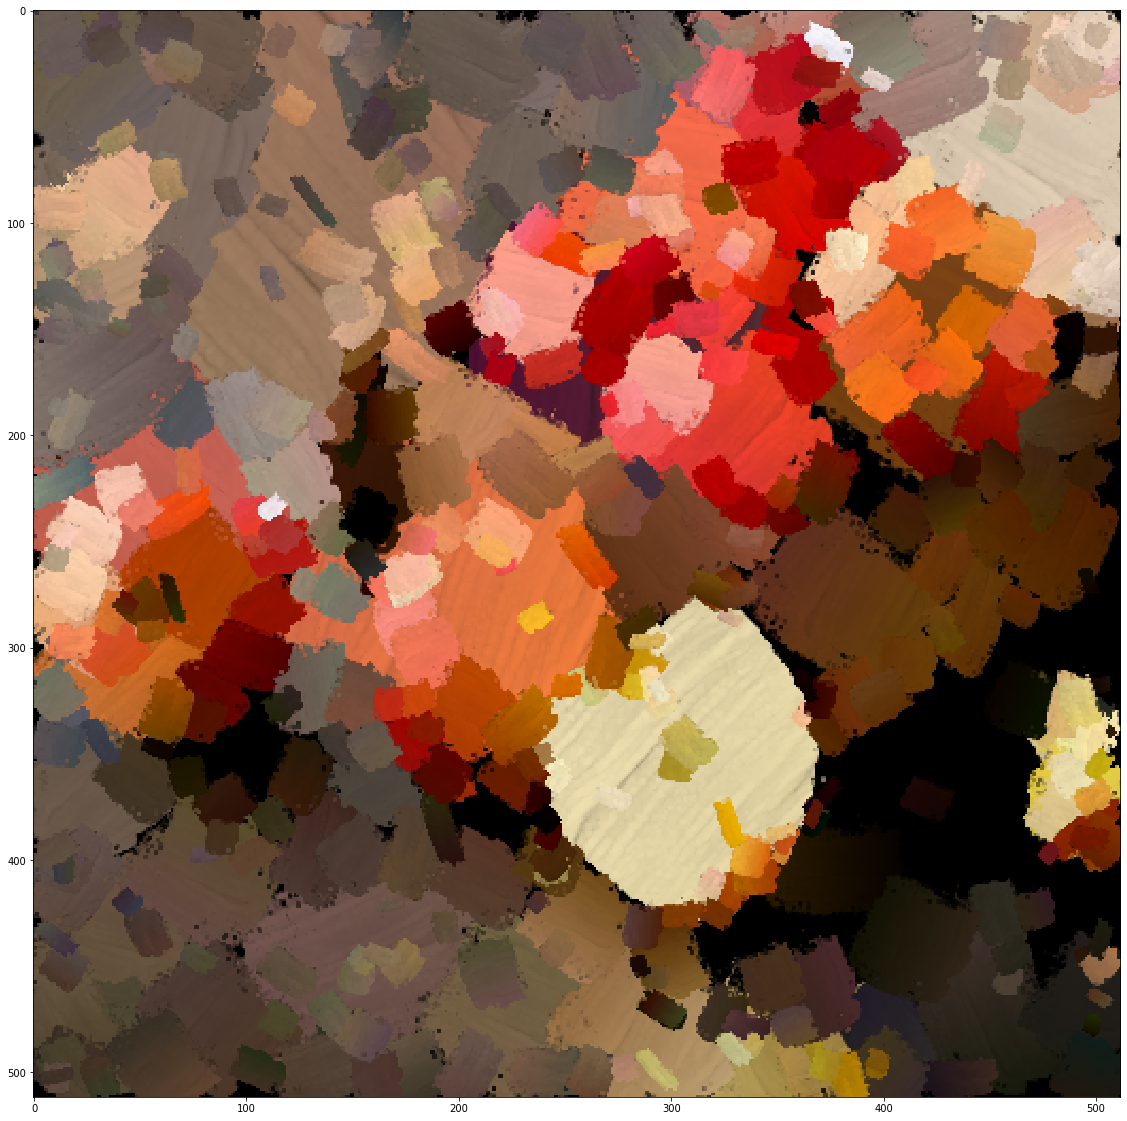

In [36]:
plt.figure(figsize=(20,20))
plt.imshow(final_rendered_image)

In [37]:
from IPython.display import Video

In [38]:
Video("output/apple_animated.mp4")